In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [163]:
df = pd.read_csv("./train.csv").drop('id',axis=1)
df_clean = df.drop('defects',axis=1)
print(df.columns)

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')


In [164]:
neg, pos = np.bincount(df['defects'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

initial_bias = np.log([pos/neg])
initial_bias = output_bias = tf.keras.initializers.Constant(initial_bias)

Examples:
    Total: 101763
    Positive: 23064 (22.66% of total)



In [165]:
print(df.describe())

                 loc           v(g)          ev(g)          iv(g)  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean       37.347160       5.492684       2.845022       3.498826   
std        54.600401       7.900855       4.631262       5.534541   
min         1.000000       1.000000       1.000000       1.000000   
25%        13.000000       2.000000       1.000000       1.000000   
50%        22.000000       3.000000       1.000000       2.000000   
75%        42.000000       6.000000       3.000000       4.000000   
max      3442.000000     404.000000     165.000000     402.000000   

                   n              v              l              d  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean       96.655995     538.280956       0.111634      13.681881   
std       171.147191    1270.791601       0.100096      14.121306   
min         0.000000       0.000000       0.000000       0.000000   
25%        25.000000      97.6700

In [166]:
eps = 0.01
for column in df_clean.columns:
    df_clean[column] = np.log(df_clean.pop(column)+eps)

(array([7.899e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 7.140e+02, 0.000e+00, 0.000e+00, 0.000e+00, 3.369e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 6.209e+03, 0.000e+00, 7.076e+03,
        0.000e+00, 7.861e+03, 0.000e+00, 6.863e+03, 5.335e+03, 5.276e+03,
        4.747e+03, 4.584e+03, 5.195e+03, 3.830e+03, 4.310e+03, 2.922e+03,
        4.764e+03, 3.921e+03, 3.257e+03, 2.173e+03, 1.393e+03, 1.654e+03,
        2.825e+03, 5.710e+02, 1.774e+03, 2.490e+02, 1.442e+03, 1.510e+02,
        1.039e+03, 2.900e+01, 0.000e+00, 3.300e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-4.60517019, -4.51286778, -4.42056537, -4.32826295, -4.23596054,
        -4.14365813, -4.05135572, -3.95905331, -3.8667509 , -3.77444849,
        -3.68214608, -3.58984367, -3.49754126, -3.40523885, -3.31293644,
        -3.22063403, -3.12833162, -3.03602921, -2.9437268 , -2.85142439,
        -2.75912198, -2.66681957, -2.57451716, -2.48221475, -2.38991234,
        -2.

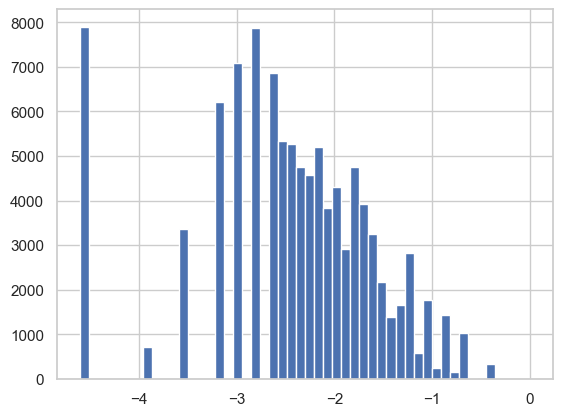

In [167]:
plt.hist(df_clean['l'],bins=50)

<Axes: >

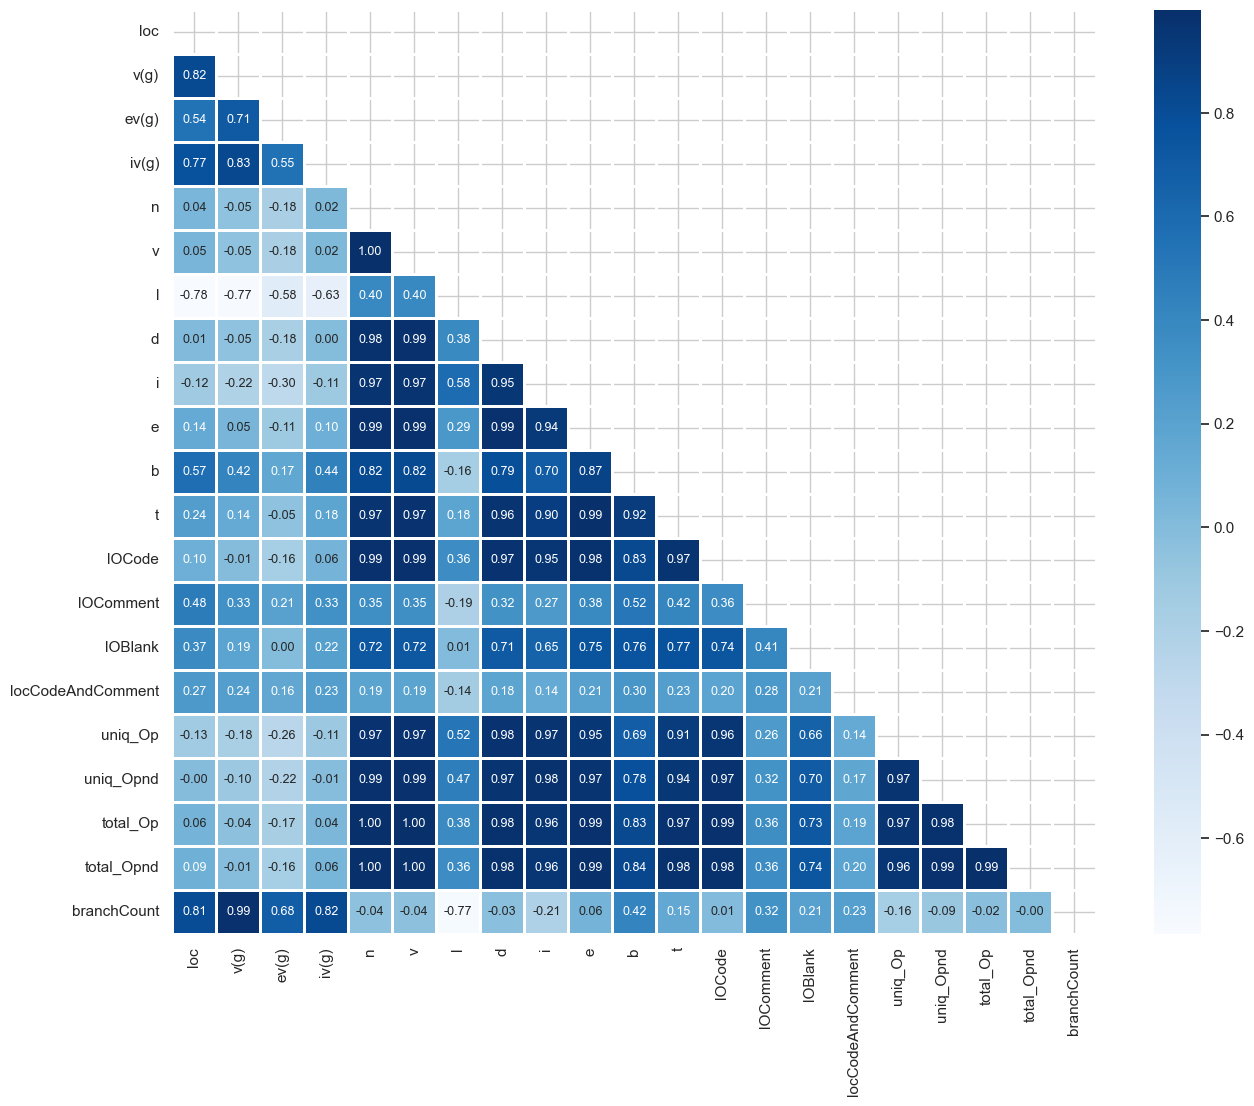

In [168]:
corr_matrix = df_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )

<Axes: >

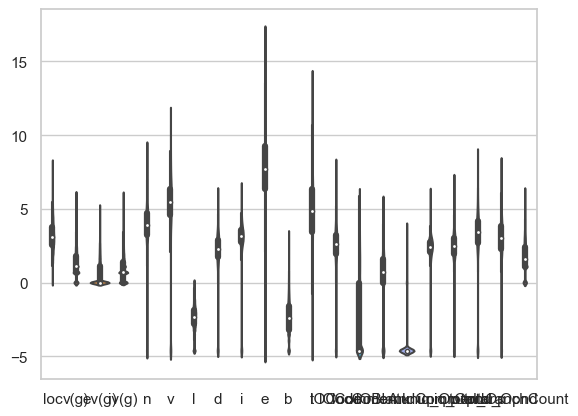

In [169]:
sns.set(style = 'whitegrid') 
sns.violinplot(data = df_clean)

In [170]:
X = df_clean
y = df['defects']

X = StandardScaler().fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(21, activation='relu',input_shape=(21,)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# ,bias_initializer=initial_bias
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

history = model.fit(X,y,epochs=100,batch_size=1000)

In [173]:
def plot_loss(history):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color='blue')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')

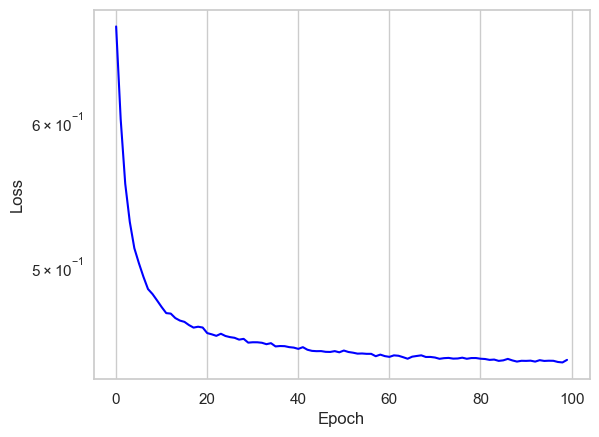

In [187]:
plot_loss(history)

In [188]:
test_X = pd.read_csv("./test.csv").drop('id',axis=1)
test_X = StandardScaler().fit_transform(test_X)

y_pred = model.predict(test_X)

print(y_pred)
submission = pd.DataFrame()

submission['id'] = np.arange(101763,101763 + len(y_pred[:67842]))
submission['defects'] = y_pred[:67842]

print(submission)
submission.to_csv("./submissionDeep7.0.csv",index=False)

2121/2121 [==============================] - 2s 1ms/step
[[0.10179614]
 [0.08547662]
 [0.55169916]
 ...
 [0.14363559]
 [0.13397752]
 [0.4346129 ]]
           id   defects
0      101763  0.101796
1      101764  0.085477
2      101765  0.551699
3      101766  0.250664
4      101767  0.131691
...       ...       ...
67837  169600  0.178304
67838  169601  0.173036
67839  169602  0.143636
67840  169603  0.133978
67841  169604  0.434613

[67842 rows x 2 columns]


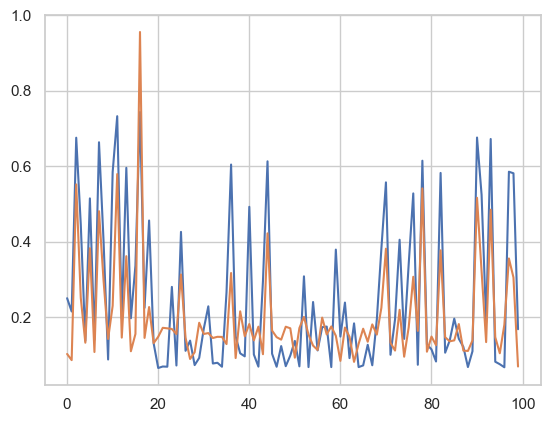

In [190]:
prece = pd.read_csv('./submission.csv')

plt.plot(np.arange(100),prece['defects'].to_list()[:100])
plt.plot(np.arange(100),submission['defects'].to_list()[:100])

In [191]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.8078415958335381

In [194]:
results = model.predict_proba(test_X)[:, 1]

submission = pd.DataFrame()

submission['id'] =  np.arange(101763,101763 + len(results))
submission['defects'] = results

print(submission)
submission.to_csv("./submission2.0.csv",index=False)

           id  defects
0      101763     0.47
1      101764     0.37
2      101765     0.54
3      101766     0.44
4      101767     0.36
...       ...      ...
67837  169600     0.35
67838  169601     0.29
67839  169602     0.32
67840  169603     0.32
67841  169604     0.53

[67842 rows x 2 columns]


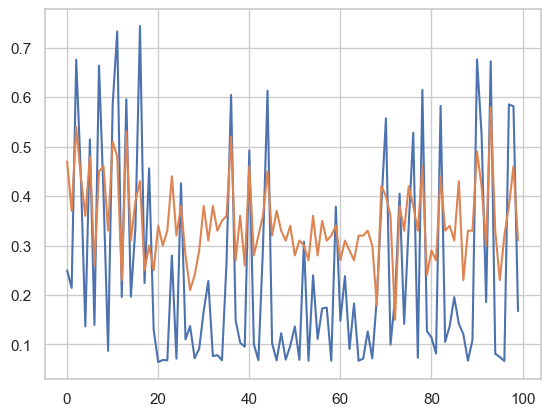

In [196]:
prece = pd.read_csv('./submission.csv')

plt.plot(np.arange(100),prece['defects'].to_list()[:100])
plt.plot(np.arange(100),submission['defects'].to_list()[:100])